In [10]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
# read videos
from os import listdir
import cv2
# others
import os
import random
import matplotlib.pyplot as plt
# SINDy
import sys
sys.path.append("src")
import sindy_utils as sindy
import numpy as np


### Functions

In [2]:
def printProgress(epoch, batch_id, loss):
    """
    print progress of the training
    epoch: number
    batch_id: current batch_id
    accuracy:
    loss:
    
    """
    progress = '='* int((10. * (batch_id+1) / len(train_data)))
    progress += '>'
    if batch_id == 0:
        print('Train Epoche {}: {}% [{}]\t , loss: {:.6f}'.format(
            epoch+1, int(100. * (batch_id+1) / len(train_data)),progress, loss.item()), end='')
    else:
        print('\rTrain Epoche {}: {}% [{}]\t , loss: {:.6f}'.format(
            epoch+1, int(100. * (batch_id+1) / len(train_data)),progress, loss.item()), end='', flush = True)
        

def networkLoss():
    """
    needs:  network['dx'], network['dx_sindy'], network['dz'],  network['dz_sindy'], network['Xi'], network['ae_loss'], 
            params['loss_weight_decoder'], params['loss_weight_sindy_x'], params['loss_weight_sindy_z'], params['loss_weight_sindy_regularization']

    calculate the loss of autoencoder and SINDy combined. loss function of:
    
     O \   _________           ________  /  O
     .    |         | \  O  / |        |    .
     . -  | phi'(x) | -  O  - | phi(z) | -  .
     .    |_________| /  O  \ |________|    .
     O /                                 \  O
    x(t)                z(t)               xa(t)
    
    ||x-phi(z)||_2^2 + lam1 ||dx - (zGrad phi(z)) Theta(z^T) Xi||_2^2 + lam2 ||dz - Theta(z^T) Xi||_2^2 + lam3 ||Xi||_1
        decoder      +                   SINDy in dx                  +         SINDy in dz             +   SINDy sparsity
     
    dz = xGrad phi'(x) dx = (xGrad z) dx
    
    network: data of the network
        network['dx'], network['dx_sindy'], network['dz'], network['dz_sindy'], network['Xi'], network['ae_loss']
    params: hyperparameters
    separate_loss: dict of loss
        separate_loss['ae_loss'], separate_loss['sindy_x_loss'], separate_loss['sindy_z_loss'], separate_loss['sparse_loss']

    return:  summed_total_loss
            and saves separate loss in network['...']
    
    """
    dx = network['dx']
    dx_sindy = network['dx_sindy']
    dz = network['dz']
    dz_sindy = network['dz_sindy']
    Xi_coeff = network['Xi']
    ae_loss = float(network['ae_loss'])
    sindy_x_loss = float(torch.mean((dx-dx_sindy)**2))
    sindy_z_loss = float(torch.mean((dz-dz_sindy)**2))
    sparse_loss = float(torch.mean(torch.abs(Xi_coeff)))
    
    # separate view of each loss
    network['ae_loss'] = ae_loss
    network['sindy_x_loss'] = sindy_x_loss
    network['sindy_z_loss'] = sindy_z_loss
    network['sparse_loss'] = sparse_loss
    
    tot_loss = (params['loss_weight_decoder'] * ae_loss
                + params['loss_weight_sindy_x'] * sindy_x_loss 
                + params['loss_weight_sindy_z'] * sindy_z_loss
                + params['loss_weight_sindy_regularization'] * sparse_loss)
                                                                                        
    return tot_loss


def calculateSindy():
    '''
    needs: network['z'], network['dz'], params['poly_order'], params['include_sine'], params['sindy_threshold']
    Calculate Theta(z) and regress to get Xi and save it in network['...']

    return: dz prediction
    
    '''
    z = network['z'].cpu().detach().numpy()
    dz = network['dz'].cpu().detach().numpy()
    
    network['Theta'] = torch.from_numpy(sindy.sindy_library(z, params['poly_order'], include_sine=params['include_sine']))
    network['Xi'] = torch.from_numpy(sindy.sindy_fit(network['Theta'], dz, params['sindy_threshold']))
    dz_predict = torch.matmul(network['Theta'],network['Xi']).cuda()
    
    return dz_predict

### Define model parameters

In [18]:
params = {}

# autoencoder settings
params['number_epoch_ae'] = 5001                         # number of epochs only autoencoder
params['number_epoch_sindy'] = 1000
params['z_dim'] = 2                                     # number of coordinates for SINDy
params['batch_size'] = 16                                # batch size
params['lr_rate'] = 1e-5                                 # learning rate
params['weight_decay'] = 1e-8                               # weight decay for NN optimizer

# loss function weighting 
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_x'] = 1e-3
params['loss_weight_sindy_z'] = 0
params['loss_weight_sindy_regularization'] = 1e-6

# SINDy parameters
params['sindy_threshold'] = 0.5 
params['poly_order'] = 4
params['include_sine'] = False

# video processing
path_train = '../../Videos/train/'
path_autoencoder = 'results/v4_lre-5_z5_poly4/Ae_600epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt'

### Data processing

In [4]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('cuda available: ', torch.cuda.is_available())
#print('cuda memory', torch.cuda.memory_summary(device=None, abbreviated=False))
torch.cuda.empty_cache()


# read the train videos in random order
file_names = []
# for f in listdir(path_train):
#     if f != 'high_res':
#         file_names.append(f)

# random.shuffle(file_names)

# for testing purpose, only take one video
file_names.append('Cu_2_Trim_low.mov')

# define transform to tensor and resize to 1080x1920, 720x404 (16:9)
# pictures are 16:9 --> 1080x1920, 900x1600, 720x1280, 576x1024, 540x960: 500k pixel, 360x640, 272x480
# normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])    # normalize around mean with sigma (std)
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((1080, 1920))])
transform = transforms.ToTensor()

# read data to list and transform to tensor
train_data_tmp = []
train_data = []
train_idxOfNewVideo = []
count = 0
for f in file_names:
    # if count == 3:
    #     break
    count += 1
    train_idxOfNewVideo.append(len(train_data))
    vidcap = cv2.VideoCapture(path_train + f)
    success,imgR = vidcap.read()
    print('Read training data:',f)
    while success:
        imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
        imgR_tensor = transform(imgR)
        train_data_tmp.append(imgR_tensor)
        success,imgR = vidcap.read()
        # make a batch
        if len(train_data_tmp) >= params['batch_size']:
            train_data.append(torch.stack(train_data_tmp))
            train_data_tmp = []
    
    print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))

vidcap.release()

print('index of new videos: ', train_idxOfNewVideo)
print('train data reading done!')


# split into validation and training set
validation_data = []
# take 10% of training set batches to validation set, take always two
nbr_batch = int(len(train_data)*0.1 / 2)
# take first two frames of a video --> goal: no interruption of the video
for i in range(0,nbr_batch):
    # choose position of train_idxOfNewVideo
    choose = random.randint(0, len(train_idxOfNewVideo)-1)
    whereInData = train_idxOfNewVideo[choose]
    # check if there are more than 3 batches of frames available
    if (train_idxOfNewVideo[choose+1] - train_idxOfNewVideo[choose]) > 3:
        element1 = train_data[whereInData]
        element2 = train_data[whereInData+1]
        validation_data.append(element1)
        validation_data.append(element2)
        train_data.pop(whereInData+1)
        train_data.pop(whereInData)
        # adapt index where new videos start in train data
        for j in range(choose+1, len(train_idxOfNewVideo)):
            train_idxOfNewVideo[j] -= 2

print('validation data construction done: ', len(validation_data), len(validation_data[0]), len(validation_data[0][0]), len(validation_data[0][0][0]))
print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))
print('index of new videos: ', train_idxOfNewVideo)


# delete not used objects
del train_data_tmp

cuda available:  True
Read training data: Cu_Fabio2_low.mov
train data:  45 16 3 404 720
Read training data: Sc_1_low.mov
train data:  106 16 3 404 720
Read training data: Ac_Fabio4_low.mov
train data:  151 16 3 404 720
index of new videos:  [0, 45, 106]
train data reading done!
validation data construction done:  14 16 3 404
train data:  137 16 3 404 720
index of new videos:  [0, 41, 100]


In [8]:
# split into test set
test_data = []
# take 10% of training set batches to test set, take always two
nbr_batch = int(len(train_data)*0.1 / 4)
# take first two frames of a video --> goal: no interruption of the video
for i in range(0,nbr_batch):
    # choose position of train_idxOfNewVideo
    choose = random.randint(0, len(train_idxOfNewVideo)-1)
    whereInData = train_idxOfNewVideo[choose]
    # check if there are more than 3 batches of frames available
    if (train_idxOfNewVideo[choose+1] - train_idxOfNewVideo[choose]) > 5:
        element1 = train_data[whereInData]
        element2 = train_data[whereInData+1]
        element3 = train_data[whereInData+2]
        element4 = train_data[whereInData+3]
        test_data.append(element1)
        test_data.append(element2)
        test_data.append(element3)
        test_data.append(element4)
        train_data.pop(whereInData+3)
        train_data.pop(whereInData+2)
        train_data.pop(whereInData+1)
        train_data.pop(whereInData)
        # adapt index where new videos start in train data
        for j in range(choose+1, len(train_idxOfNewVideo)):
            train_idxOfNewVideo[j] -= 4

print('test data construction done: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]))
print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))

# save training, validation and test data
name_path = 'results/v5/data/'
torch.save(train_data, name_path + 'train_data.pt')
torch.save(validation_data, name_path + 'validation_data.pt')
torch.save(test_data, name_path + 'test_data.pt')

Read: Ac_timelapse_sunrise_low.mov
Read: Cb_2_low.mov
Read: St_Fabio1_low.mov
test data reading done:  889 3 404 720


In [ ]:
# plot some frames and test prints
print(torch.min(train_data[0]), torch.max(train_data[0]))
print(train_data[0].permute(3,2,1,0).size())

# plot first frame per batch
for i in range(len(train_data)):
    if i%3 == 0:
        plt.figure()
    imgP = train_data[i][0].permute(1,2,0).detach().numpy()
    plt.subplot(1,3, i%3 + 1)
    plt.imshow(imgP)


### SINDy autoencoder

In [5]:
# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        # TODO: Dopoutlayers --> in the end to fine tune
        self.fc1 = nn.Linear(200*8*10,params['z_dim'])
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(params['z_dim'], 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        elif mode == 'test':
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            print(mode, 'is not an adequate in the forward path')

        return encoded, decoded


loaded autoencoder results/run1_lre-5_z5_poly4/Ae_600epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt
torch.Size([16, 3, 404, 720])
torch.Size([16, 3, 404, 720])
torch.Size([16, 5])


UnboundLocalError: local variable 'loss_category' referenced before assignment

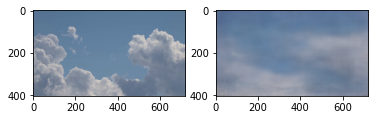

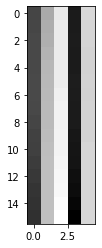

In [23]:
# # load model
# if os.path.isfile(path_autoencoder):
#     autoencoder = torch.load(path_autoencoder)
#     autoencoder = autoencoder.cpu()
#     print('loaded autoencoder', path_autoencoder)
# else:
#     autoencoder = Autoencoder()
#     autoencoder = autoencoder.cpu()        # or .cuda()
#     print('loaded new autoencoder')


# to save network data and initialize loss values
network = {}
network['combined_loss'] = 0
network['sindy_x_loss'] = 0
network['sindy_z_loss'] = 0
network['sparse_loss'] = 0

# training function
def train(epoch, phase):
    '''
    training function for the autoencoder: 
        use train_idxOfNewVideo to check if the current batch correspond to a new video

    epoch: current epoch of learning
    phase: 'autoencoder', 'sindy' --> first train only auto encoder (pretrain), then with the sindy loss terms

    '''
    # train only with autoencoder
    if phase == 'autoencoder':
        for batch_id, img_tensor in enumerate(train_data):
            img_tensor = img_tensor#.cuda()
            encode_tensor, recon_tensor = autoencoder(img_tensor, 0, mode='train')
            network['ae_loss'] = criterion(recon_tensor, img_tensor)
            network['combined_loss'] = network['ae_loss']
            combined_loss = network['ae_loss']

            # optimization step
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

            # tensorboard
            writer.add_scalar('Training loss per batch in autoencoder phase', combined_loss, global_step=step_train)
            writer.add_histogram('fc1', autoencoder.fc1.weight)
            step_train += 1

            # printProgress(epoch, batch_id, combined_loss)
            img_tensor = img_tensor.detach()
    
    # train with autoencoder and sindy
    elif phase == 'sindy':
        pos = 0
        for batch_id, img_tensor in enumerate(train_data):
            img_tensor = img_tensor#.cuda()
            encode_tensor, recon_tensor = autoencoder(img_tensor, 0, mode='train')
            network['ae_loss'] = criterion(recon_tensor, img_tensor)
            
            # x, z is current batch_id, dx, dz is next one (in else we take dz as current and compare with x from before, the excite to current step)
            if batch_id == train_idxOfNewVideo[pos]:
                pos += 1
                combined_loss = network['ae_loss']       
                network['z'] = encode_tensor#.float()
            else:
                network['dx'] = img_tensor#.float()
                network['dz'] = encode_tensor#.float()
                network['dz_sindy'] = calculateSindy().float()
                _, network['dx_sindy'] = autoencoder(0, network['dz_sindy'], mode='test')
                combined_loss = networkLoss()            # total loss with SINDy
                # now advance one step
                network['z'] = network['dz']
                    
            # optimization and backpropagation
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

            # tensorboard
            writer.add_scalar('Training loss per batch in sindy phase', combined_loss, global_step=step_train)
            writer.add_histogram('fc1', autoencoder.fc1.weight)
            step_train += 1

            # printProgress(epoch, batch_id, combined_loss)
            img_tensor = img_tensor.detach()
    else:
        print('No such training phase available:', phase)

    
    print('\n')

    # hyperparametering with the last losses of the epoch
    writer.add_hparams({'lr': lr_rate, 'zDimension': dimZ}, 
           {'auto encoder loss': network['ae_loss'],'combined loss': network['combined_loss'], 'sindy x loss': network['sindy_x_loss'], 'sparsity loss': network['sparse_loss']})
    
    # delete from cuda
    del encode_tensor
    del recon_tensor


# evaluation function
def evaluate(phase):
    '''
    evaluation of the training by it's loss

    '''
    autoencoder.eval()

    # train only with autoencoder
    if phase == 'autoencoder':
        evaluated_combined_loss = 0
        for i, img_tensor in enumerate(validation_data):
            img_tensor = img_tensor#.cuda()
            encode_eval_tensor, recon_eval_tensor = autoencoder(img_tensor, 0, mode='train')
            network['ae_loss'] = criterion(recon_eval_tensor, img_tensor)
            evaluated_combined_loss += network['ae_loss']

        # append average loss of this epoch
        evaluated_combined_loss_perData = evaluated_combined_loss/len(validation_data)
        writer.add_scalar('Evaluation combined loss per epoch in autoencoder phase', evaluated_combined_loss_perData, global_step=step_eval)
        step_eval += 1

    # train with autoencoder and sindy
    elif phase == 'sindy':
        evaluated_combined_loss = 0
        evaluated_sindy_loss = 0
        for i, img_tensor in enumerate(validation_data):
            img_tensor = img_tensor#.cuda()
            encode_eval_tensor, recon_eval_tensor = autoencoder(img_tensor, 0, mode='train')
            network['ae_loss'] = criterion(recon_eval_tensor, img_tensor)

            # first batch
            if i % 2 == 0:
                # x, z are at the current time
                network['z'] = encode_eval_tensor#.float()
                
            # second batch, evaluation
            else:
                network['dx'] = img_tensor#.float()
                network['dz'] = encode_eval_tensor#.float()
                eval_theta = torch.from_numpy(sindy.sindy_library(network['z'].cpu().detach().numpy(), params['poly_order'], include_sine=params['include_sine']))
                network['dz_sindy'] = torch.matmul(eval_theta,network['Xi']).float()#.cuda()
                
                _, network['dx_sindy'] = autoencoder(0, network['dz_sindy'], mode='test')
                combined_loss = networkLoss()            # total loss with SINDy

                # loss
                evaluated_combined_loss += combined_loss
                evaluated_sindy_loss += network['sindy_x_loss']
        
        # append average loss of this epoch
        evaluated_combined_loss_perData = evaluated_combined_loss/len(validation_data)*2
        evaluated_sindy_loss_perData = evaluated_sindy_loss/len(validation_data)*2
        writer.add_scalar('Evaluation combined loss per epoch in sindy phase', evaluated_combined_loss_perData, global_step=step_eval)
        writer.add_scalar('Evaluation sindy x loss per epoch in sindy phase', evaluated_sindy_loss_perData, global_step=step_eval)
        step_eval += 1
    else:
        print('No such evaluation phase available:', phase)


    del encode_eval_tensor
    del recon_eval_tensor



# print to tensorboard and hyperparameter search
# lr_rate_arr = [0.01, 0.001, 0.0001, 0.00001]
# dim_z_arr = [1, 2, 3, 5, 10, 20]
lr_rate_arr = [params['lr_rate']]
dim_z_arr = [params['z_dim']]

for lr_rate in lr_rate_arr:
    params['lr_rate'] = lr_rate
    for dimZ in dim_z_arr:
        params['z_dim'] = dimZ
        writer = SummaryWriter(f'runs/v5Tensorboard/trainLoss_LR{lr_rate}_dimZ{dimZ}')
        step_train = 0
        step_eval = 0

        # load new network
        autoencoder = Autoencoder()
        autoencoder = autoencoder.cuda()
        # optimization technique
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=params['lr_rate'], weight_decay=params['weight_decay'])

        # epoch loop
        for epoch in range(params['number_epoch_ae'] + params['number_epoch_sindy']):
            # first train only autoencoder
            if epoch < params['number_epoch_ae']:
                train(epoch, phase='autoencoder')
                print('train epoch', epoch, 'in phase autoencoder done')
                evaluate(phase='autoencoder')
                print('evaluate epoch', epoch, 'in phase autoencoder done')
            # afterwards train network with sindy
            else:
                train(epoch, phase='sindy')
                print('train epoch', epoch, 'in phase sindy done')
                evaluate(phase='sindy')
                print('evaluate epoch', epoch, 'in phase sindy done')

            # save model every 1000 epoch
            if epoch % 1000 == 0:
                name_Ae = 'results/v5/Ae_' + str(epoch) + 'epoch_bs16_lr{lr_rate}_z{dimZ}_sindt05_poly5.pt'
                name_Xi = 'results/v5/Xi_' + str(epoch) + 'epoch_bs16_lr{lr_rate}_z{dimZ}_sindth05_poly5.pt'
                torch.save(autoencoder, name_Ae)
                torch.save(network['Xi'], name_Xi)
                print('saved model in epoch', epoch)

    torch.cuda.empty_cache()

print('training finished!')

### Prediction and plots

In [ ]:
# SINDy prediction --> split up model that I can plug in z
t = np.arange(0,20,.01)
z_sim = sindy.sindy_simulate(network['z'], t, network['Xi'], params['poly_order'], params['include_sine'])

In [ ]:
# plots
print(network['Theta'].shape, network['Xi'].shape)
#print(network['Xi'])

print('reconstruction loss', categorie_loss[0],'\n sindy x loss', categorie_loss[1], 
      '\n sindy z loss', categorie_loss[2], '\n Xi sparsity loss', categorie_loss[3])
print(network['ae_loss'])

for i in range(0, params['number_epoch']):
    plt.figure()
    realImg = outputs[i][1].permute(0,2,3,1).detach().numpy()
    reconImg = outputs[i][2].permute(0,2,3,1).detach().numpy()
    for i, item in enumerate(realImg):
        if i >=4: break
        plt.subplot(2,4,i+1)
        plt.imshow(item)
    for i, item in enumerate(reconImg):
        if i >=4: break
        plt.subplot(2,4,4+i+1)
        plt.imshow(item)    


In [92]:
## for testing
#Xi = np.ones((5,2))
#Xi[1,1] = 4
#Xi[3,0] = 0.01
#Xi[2,1] = 1.2
#Xi[4,1] = 0.09
#print(Xi)
#small_inds = (np.abs(Xi) < 0.1)
#print(small_inds)
#Xi[small_inds] = 0
#print(Xi)

haList = [[]]
haList[0].append(5)
haList[0].append(6)
print(haList)
haList.append([1])
haList[1].append(2)
print(haList)

print(len(haList), len(haList[0]))
haList = [[3,3],[4,2],[5,34]]
print(haList)
haList[2][1] = 0
print(haList)
haList[2].append([10,9])
print(haList)



# only use one list to read data --> less memory and faster!
readTest = [[]]
readTest_tensor = torch.ones((2,5))
readTest_tensor2 = torch.zeros((2,5))
batch_id_local = 0
print(readTest)
for i in range(100):
    #print(batch_id_local, i)
    if i % 16 == 0 and i != 0:
        batch_id_local += 1
        readTest.append([readTest_tensor2])
    else:
        readTest[batch_id_local].append(readTest_tensor)

if len(readTest[batch_id_local]) < batch_id_local:
    readTest.remove(readTest[batch_id_local])

print(len(readTest), len(readTest[0]),len(readTest[0][0]),len(readTest[0][0][0]))


[[5, 6]]
[[5, 6], [1, 2]]
2 2
[[3, 3], [4, 2], [5, 34]]
[[3, 3], [4, 2], [5, 0]]
[[3, 3], [4, 2], [5, 0, [10, 9]]]
[[]]
6 16 2 5
